In [1]:
import sys ###dppolicyagent
sys.path.append('../scripts/')
from puddle_world import *
import itertools
import collections
import random

In [2]:
class DpPolicyAgent(KfAgent):  ###dppolicyagent
    def __init__(self, time_interval, init_pose, envmap, \
                motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, widths=np.array([0.2, 0.2, math.pi/18]).T, \
                 lowerleft=np.array([-4, -4]).T, upperright=np.array([4, 4]).T): #widths以降はDynamicProgrammingから持ってくる
        super().__init__(time_interval, 0.0, 0.0, init_pose, envmap, motion_noise_stds) 
        
        ###座標関連の変数をDynamicProgrammingから持ってくる###
        self.pose_min = np.r_[lowerleft, 0] 
        self.pose_max = np.r_[upperright, math.pi*2]
        self.widths = widths
        self.index_nums = ((self.pose_max - self.pose_min)/self.widths).astype(int)
        
        self.policy_data = self.init_policy()
        
    def init_policy(self):
        tmp = np.zeros(np.r_[self.index_nums,2])
        for line in open("tmp/q_policy2800000.txt", "r"):
            d = line.split()
            tmp[int(d[0]), int(d[1]), int(d[2])] = [float(d[3]), float(d[4])]
            
        return tmp
        
    def policy(self, pose): #姿勢から離散状態のインデックスを作って方策を参照して返すだけ
        index = np.floor((pose - self.pose_min)/self.widths).astype(int)           #姿勢からインデックスに
        
        index[2] = (index[2] + self.index_nums[2]*1000)%self.index_nums[2] #角度の正規化
        for i in [0,1]:                                                                                   #端の処理（内側の座標の方策を使う）
            if index[i] < 0: index[i] = 0
            elif index[i] >= self.index_nums[i]: index[i] = self.index_nums[i] - 1
                
        a = self.policy_data[tuple(index)]
        return self.policy_data[tuple(index)] if random.random() > 0.3 else random.choice([[1, 0],[0, -2], [0, 2]]) 
        
    def decision(self, observation=None):
        self.kf.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        self.kf.observation_update(observation)
        
        nu, omega = self.policy(self.kf.belief.mean)
        self.prev_nu, self.prev_omega = nu, omega
        return nu, omega

<IPython.core.display.Javascript object>


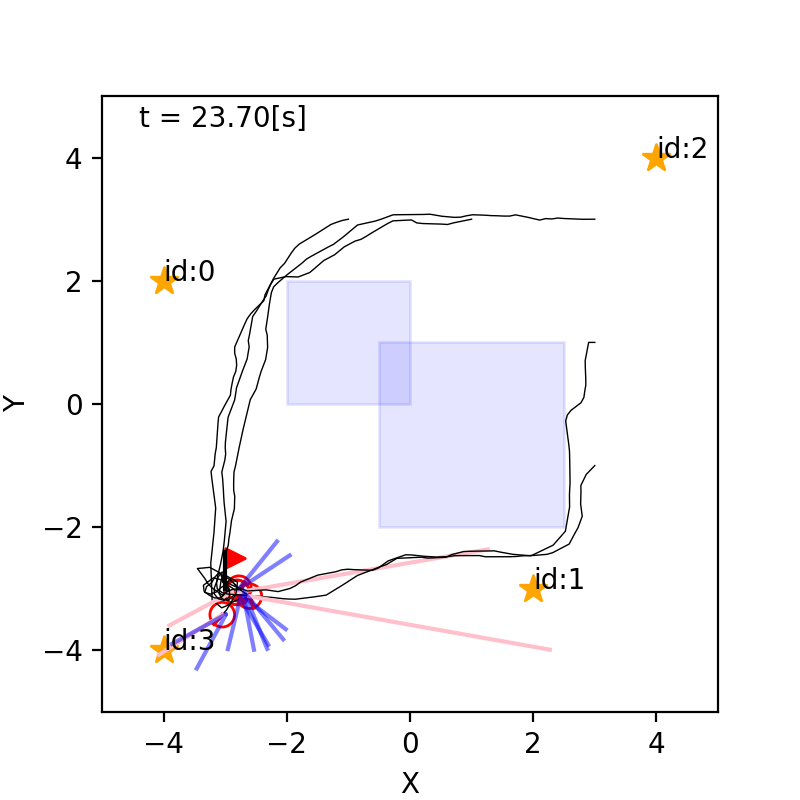

In [3]:
if __name__ == '__main__':  ###dppolicyagentrun
    time_interval = 0.1
    world = PuddleWorld(300, time_interval) 

    m = Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(4,4))
    m.append_landmark(Landmark(-4,-4))
    world.append(m)
    
    ###ゴールの追加###
    goal = Goal(-3,-3)
    world.append(goal)
    
    ###水たまりの追加###
    world.append(Puddle((-2, 0), (0, 2), 0.1)) 
    world.append(Puddle((-0.5, -2), (2.5, 1), 0.1))

    ### いくつかの初期位置を定義 ###   ###dppolicyagentrun
    init_poses = []
    for p in [[-1, 3, math.pi], [1, 3, math.pi], [3, 3, math.pi], [3, 1, math.pi], [3, -1, math.pi]]:
        init_pose = np.array(p).T
    
        a = DpPolicyAgent(time_interval, init_pose, m)
        r = Robot(init_pose, sensor=Camera(m, distance_bias_rate_stddev=0, direction_bias_stddev=0), 
              agent=a, color="red", bias_rate_stds=(0,0))

        world.append(r)
        
    world.draw()
    #r.one_step(0.1) #デバッグ時